# Intent Model Training
This notebook retrains the transformer-based intent classifier that powers `src/services/behavior/sticker.py`. It consumes the artefacts created by the analysis notebook (or rebuilds them if needed), fine-tunes the model, evaluates it thoroughly, and persists everything under `assets/models/intent_predictor`.

## Workflow
1. Resolve project/root paths and hyperparameters.
2. Load the cleaned dataset (or regenerate it from raw jsonl files).
3. Visualize the training distribution for sanity checking.
4. Tokenize data with the Hugging Face tokenizer and train via `Trainer`.
5. Produce metrics, confusion matrices, and qualitative samples.
6. Persist the model, tokenizer, mappings, metrics, and plots back to `assets/models/intent_predictor`.

In [24]:
from __future__ import annotations

import json
import shutil
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

import torch

pd.set_option("display.max_rows", 100)
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = ["Microsoft YaHei", "SimHei", "sans-serif"]

In [25]:
NOTEBOOK_DIR = Path().resolve()


def find_project_root(start: Path) -> Path:
    for candidate in [start] + list(start.parents):
        if (candidate / "assets" / "models").exists():
            return candidate
    raise RuntimeError("Could not locate project root")


PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
ASSETS_DIR = PROJECT_ROOT / "assets"
MODELS_DIR = ASSETS_DIR / "models"
DATA_DIR = MODELS_DIR / "few_shot_intent_sft" / "data"
MODEL_DIR = MODELS_DIR / "intent_predictor"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_DATA_PATH = MODEL_DIR / "clean_wechat_intents.parquet"
TRAINING_DATA_SNAPSHOT = MODEL_DIR / "training_dataset_snapshot.parquet"
REPORT_PATH = MODEL_DIR / "evaluation_metrics.json"
CLASSIFICATION_REPORT_PATH = MODEL_DIR / "classification_report.csv"
CONFUSION_MATRIX_PATH = MODEL_DIR / "confusion_matrix.png"
TRAINING_SUMMARY_PATH = MODEL_DIR / "training_summary.json"
LABEL_MAPPING_PATH = MODEL_DIR / "intent_mapping.json"

MODEL_NAME = "hfl/chinese-bert-wwm-ext"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5
TEST_SIZE = 0.2
RANDOM_SEED = 42
ENABLE_BACKUP = True

print(f"Project root: {PROJECT_ROOT}")
print(f"Model output directory: {MODEL_DIR}")
print(f"Processed dataset path: {PROCESSED_DATA_PATH}")

Project root: D:\Files\Develop Projects\AI\Yuzuriha-Rin
Model output directory: D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor
Processed dataset path: D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor\clean_wechat_intents.parquet


In [26]:
BLACKLIST_INTENTS = {
    "查询类",
    "查询(产品信息)",
    "查询(价格)",
    "查询(优惠)",
    "查询(库存)",
    "查询(物流)",
    "查询(订单)",
    "查询(账户)",
    "查询(余额)",
    "实体(产品)",
    "实体(价格)",
    "实体(时间)",
    "实体(地点)",
    "实体(人名)",
    "实体(公司)",
    "实体识别",
    "产品推荐",
    "促销活动",
    "优惠信息",
    "下单",
    "支付",
    "退款",
    "投诉",
    "售后",
    "政治敏感",
    "污言秽语",
    "色情低俗",
    "暴力血腥",
    "违法犯罪",
    "广告营销",
    "诈骗信息",
    "肯定(没问题)",
    "否定(没有)",
    "转人工",
    "挂断电话",
    "保持通话",
    "重复",
    "澄清",
    "确认信息",
    "核实身份",
    "录音提示",
    "系统提示",
}

RAW_DATASETS = [
    ("telemarketing", DATA_DIR / "telemarketing_intent_cn.jsonl"),
    ("crosswoz", DATA_DIR / "crosswoz.jsonl"),
]


def read_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)


def load_or_build_dataset() -> pd.DataFrame:
    if PROCESSED_DATA_PATH.exists():
        print(f"Loading cached dataset from {PROCESSED_DATA_PATH}")
        df = pd.read_parquet(PROCESSED_DATA_PATH)
        df["dataset"].fillna("telemarketing", inplace=True)
        return df

    frames = []
    for name, path in RAW_DATASETS:
        if not path.exists():
            print(f"Skipping {name}: {path} not found")
            continue
        df = read_jsonl(path)
        df["dataset"] = name
        frames.append(df)
    if not frames:
        raise FileNotFoundError(
            "No raw datasets available. Please populate assets/models/few_shot_intent_sft/data"
        )
    merged = pd.concat(frames, ignore_index=True)
    merged["text"] = merged["text"].astype(str)
    cleaned = merged[~merged["label"].isin(BLACKLIST_INTENTS)].copy()
    label_counts = cleaned["label"].value_counts()
    keep_labels = label_counts[label_counts >= 20].index
    cleaned = cleaned[cleaned["label"].isin(keep_labels)].copy()

    capped_parts = []
    for label, group in cleaned.groupby("label"):
        if len(group) > 300:
            sample = group.sample(n=300, random_state=RANDOM_SEED)
        else:
            sample = group
        capped_parts.append(sample)
    capped = pd.concat(capped_parts, ignore_index=True)
    capped = capped.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)
    capped["text_length"] = capped["text"].str.len()
    capped.to_parquet(PROCESSED_DATA_PATH, index=False)
    print(f"Cached dataset saved to {PROCESSED_DATA_PATH}")
    return capped

In [27]:
dataset_df = load_or_build_dataset()
print(f"Dataset shape: {dataset_df.shape}")
print(f"Unique intents: {dataset_df['label'].nunique()}")

dataset_df.head()

Loading cached dataset from D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor\clean_wechat_intents.parquet
Dataset shape: (10140, 6)
Unique intents: 73


C:\Users\Leever\AppData\Local\Temp\ipykernel_10008\3498971071.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dataset"].fillna("telemarketing", inplace=True)


,text,label,data_source,split,dataset,text_length
0,晚点马上还,会按时处理,telemarketing_intent_cn,train,telemarketing,5
1,都不要,否定(不需要),telemarketing_intent_cn,test,telemarketing,3
2,到底多少钱,疑问(数值),telemarketing_intent_cn,train,telemarketing,5
3,下个月再还,答时间,telemarketing_intent_cn,train,telemarketing,5
4,还在嘛,你还在吗,telemarketing_intent_cn,train,telemarketing,3


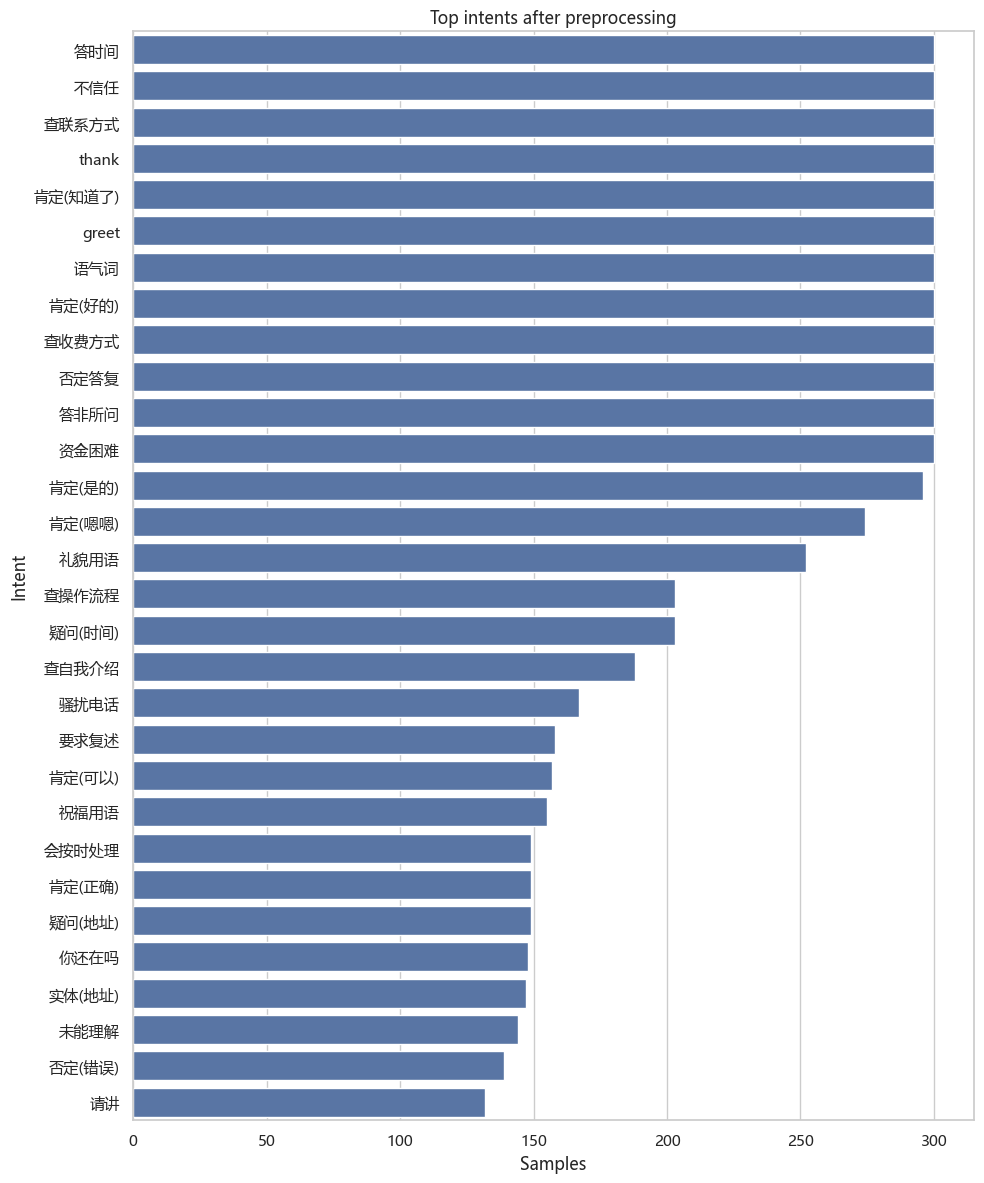

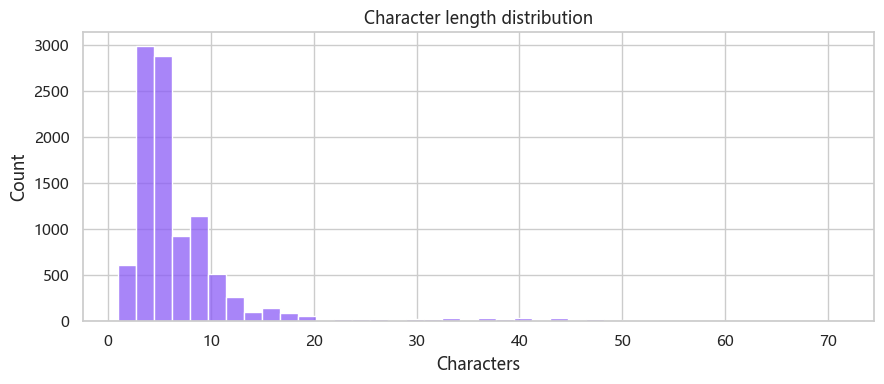

In [28]:
intent_counts = dataset_df["label"].value_counts()
plt.figure(figsize=(10, 12))
sns.barplot(x=intent_counts.head(30).values, y=intent_counts.head(30).index)
plt.title("Top intents after preprocessing")
plt.xlabel("Samples")
plt.ylabel("Intent")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
sns.histplot(dataset_df["text"].str.len(), bins=40, color="#8b5cf6")  # type: ignore
plt.title("Character length distribution")
plt.xlabel("Characters")
plt.tight_layout()
plt.show()

In [29]:
labels = sorted(dataset_df["label"].unique())
intent2id = {label: idx for idx, label in enumerate(labels)}
id2intent = {idx: label for label, idx in intent2id.items()}

dataset_df["label_id"] = dataset_df["label"].map(intent2id)

train_df, test_df = train_test_split(
    dataset_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=dataset_df["label_id"],
)

print(f"Train rows: {len(train_df):,}")
print(f"Test rows: {len(test_df):,}")
train_df.head()

Train rows: 8,112
Test rows: 2,028


,text,label,data_source,split,dataset,text_length,label_id
3275,怎么计费,查收费方式,telemarketing_intent_cn,train,telemarketing,4,36
8567,什么意思 不懂,未能理解,telemarketing_intent_cn,train,telemarketing,9,32
7719,"恩,好的",肯定(好的),telemarketing_intent_cn,train,telemarketing,4,55
4428,等下给他讲,请等一等,telemarketing_intent_cn,test,telemarketing,5,63
4113,没听太清,听不清楚,telemarketing_intent_cn,train,telemarketing,4,21


In [30]:
def dataframe_to_dataset(df: pd.DataFrame) -> Dataset:
    return Dataset.from_pandas(
        df[["text", "label_id"]].rename(columns={"label_id": "label"})
    )


hf_dataset = DatasetDict(
    {
        "train": dataframe_to_dataset(train_df),
        "test": dataframe_to_dataset(test_df),
    }
)

hf_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 8112
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2028
    })
})

In [31]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(intent2id),
)
model.config.id2label = id2intent
model.config.label2id = intent2id


def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        max_length=MAX_LENGTH,
        truncation=True,
    )


encoded_dataset = hf_dataset.map(tokenize_function, batched=True)
encoded_dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-bert-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 2028/2028 [00:00<00:00, 25036.42 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8112
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2028
    })
})

In [32]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }


training_args = TrainingArguments(
    output_dir=str(MODEL_DIR / "checkpoints"),
    eval_strategy="epoch",  # type: ignore
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,  # type: ignore
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
train_result

C:\Users\Leever\AppData\Local\Temp\ipykernel_10008\474538040.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,1.606900,1.341961,0.787475,0.761391
2,0.819100,0.786602,0.859467,0.856249
3,0.532600,0.626694,0.876233,0.874601
4,0.396600,0.594578,0.879684,0.878501


TrainOutput(global_step=2028, training_loss=1.16100666885075, metrics={'train_runtime': 255.2088, 'train_samples_per_second': 127.143, 'train_steps_per_second': 7.946, 'total_flos': 2135717491654656.0, 'train_loss': 1.16100666885075, 'epoch': 4.0})

In [33]:
eval_metrics = trainer.evaluate()
print("Evaluation metrics:")
for key, value in eval_metrics.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

test_predictions = trainer.predict(encoded_dataset["test"])  # type: ignore
pred_labels = np.argmax(test_predictions.predictions, axis=-1)
true_labels = test_predictions.label_ids

report = classification_report(
    true_labels,  # type: ignore
    pred_labels,
    target_names=[id2intent[i] for i in range(len(id2intent))],
    zero_division=0,
    output_dict=True,
)
report_df = pd.DataFrame(report).transpose()
report_df.head()

Evaluation metrics:
  eval_loss: 0.5946
  eval_accuracy: 0.8797
  eval_f1_weighted: 0.8785
  eval_runtime: 4.6226
  eval_samples_per_second: 438.7150
  eval_steps_per_second: 13.8450
  epoch: 4.0000


,precision,recall,f1-score,support
bye,0.764706,1.000000,0.866667,13.0
greet,1.000000,0.933333,0.965517,60.0
thank,0.934426,0.950000,0.942149,60.0
不信任,0.966667,0.966667,0.966667,60.0
价格太高,1.000000,1.000000,1.000000,17.0


### Confusion matrix and per-intent F1
Visual diagnostics help catch degenerate classes and guide data collection.

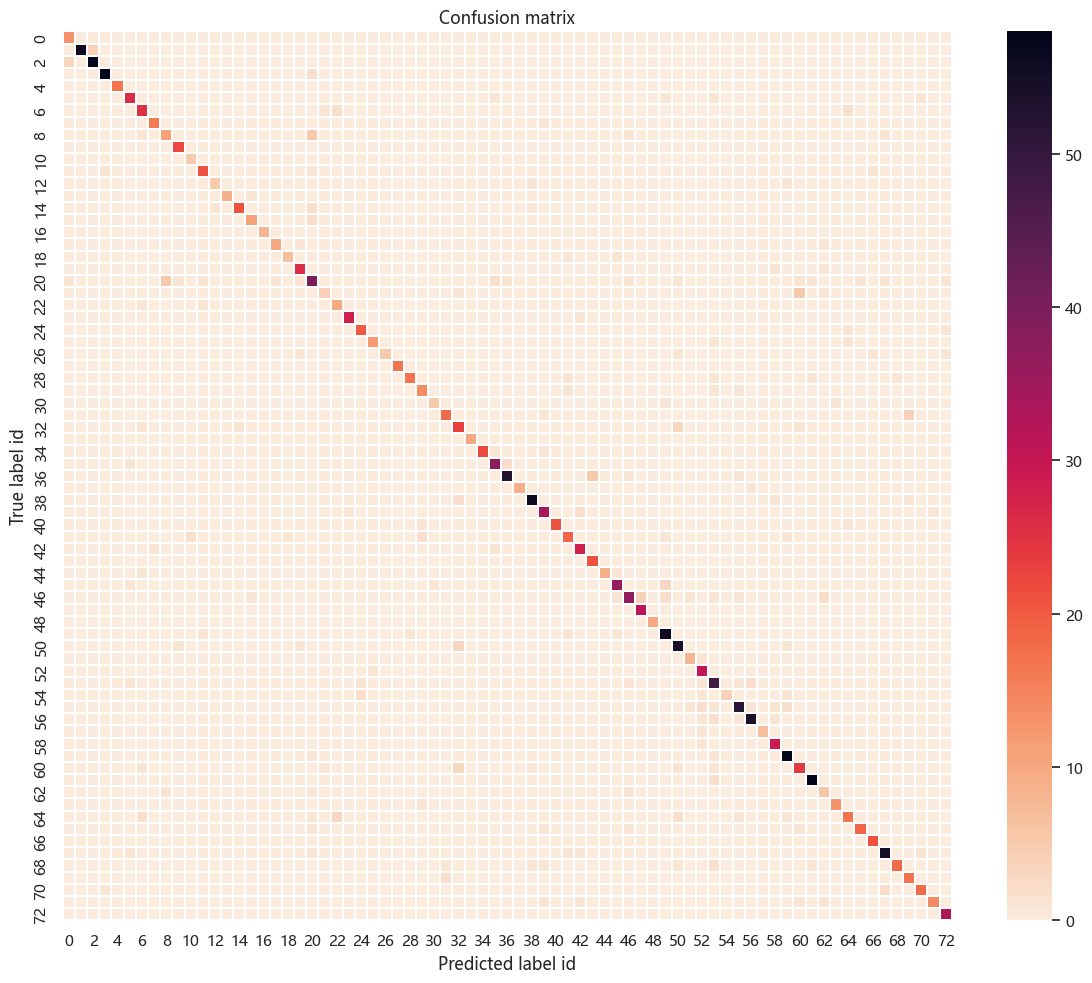

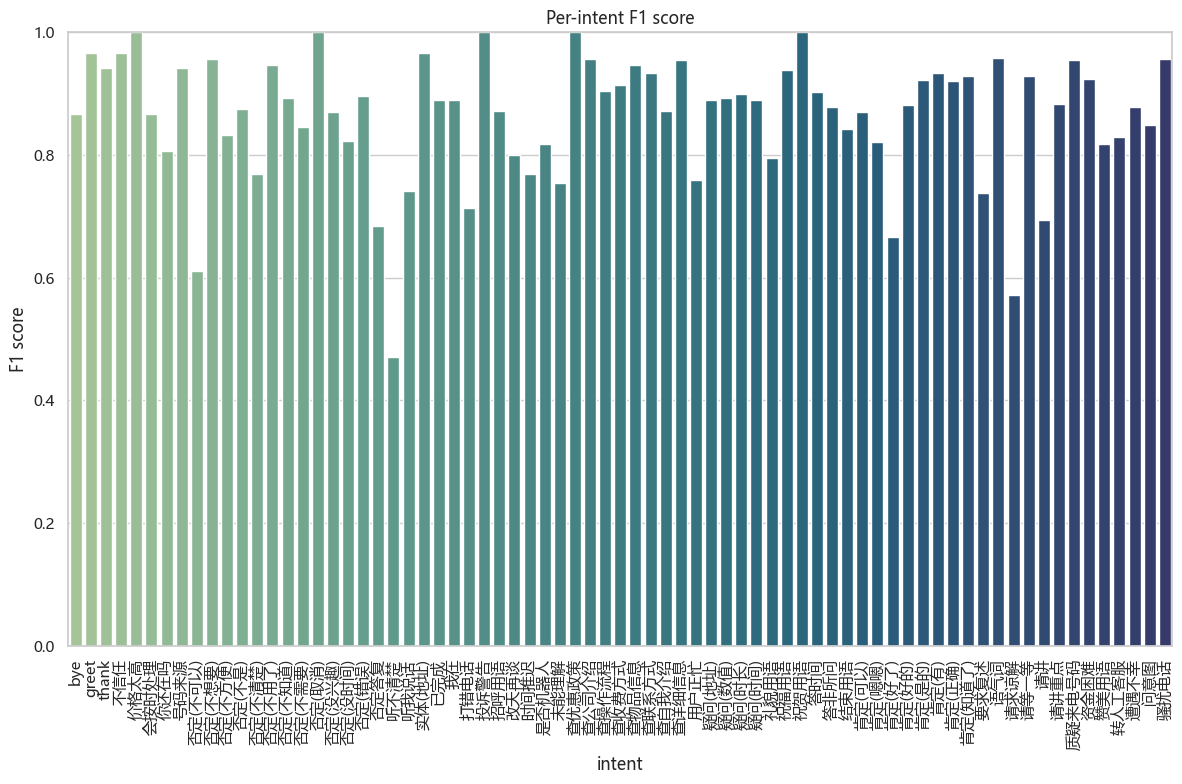

In [34]:
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(intent2id))))  # type: ignore
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="rocket_r", linewidths=0.1)
plt.title("Confusion matrix")
plt.xlabel("Predicted label id")
plt.ylabel("True label id")
plt.tight_layout()
plt.show()

per_intent = (
    report_df.drop(index=["accuracy", "macro avg", "weighted avg"], errors="ignore")
    .reset_index()
    .rename(columns={"index": "intent"})
)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=per_intent,
    x="intent",
    y="f1-score",
    hue="intent",
    palette="crest",
    legend=False,
)
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("Per-intent F1 score")
plt.ylabel("F1 score")
plt.tight_layout()
plt.show()

### Hardest samples
Review a few mismatches sorted by confidence gap.

In [35]:
probs = torch.nn.functional.softmax(
    torch.tensor(test_predictions.predictions), dim=-1
).numpy()
confidences = probs[np.arange(len(pred_labels)), pred_labels]

error_mask = pred_labels != true_labels
errors_df = pd.DataFrame(
    {
        "text": test_df.reset_index(drop=True).loc[error_mask, "text"],
        "true_intent": [id2intent[idx] for idx in true_labels[error_mask]],  # type: ignore
        "pred_intent": [id2intent[idx] for idx in pred_labels[error_mask]],
        "confidence": confidences[error_mask],
    }
)

errors_df.sort_values("confidence", ascending=False).head(10)

,text,true_intent,pred_intent,confidence
40,明天一定能还得掉,会按时处理,答时间,0.960994
703,"不行啊,没钱了",否定(不可以),资金困难,0.958453
1047,明天上午走还是下午,疑问(时间),答时间,0.958398
716,啥四零零,要求复述,查联系方式,0.958341
712,"好的,收到!",肯定(好的),肯定(知道了),0.951854
1818,是!长官!,肯定(好的),肯定(是的),0.951822
1169,不是怎么靠谱,否定(不是),不信任,0.950476
1110,哦。。。好,肯定(嗯嗯),肯定(好的),0.948633
940,天知道,否定(不清楚),肯定(知道了),0.948565
17,"好的,我在路上",肯定(是的),肯定(好的),0.948439


### Persist artefacts
The sticker service expects the model, tokenizer, and `intent_mapping.json` inside `assets/models/intent_predictor`. Metrics and plots are stored alongside for quick auditing.

In [36]:
if ENABLE_BACKUP and MODEL_DIR.exists() and any(MODEL_DIR.iterdir()):
    backup_dir = MODEL_DIR.parent / "intent_predictor_backups"
    backup_dir.mkdir(parents=True, exist_ok=True)
    timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    snapshot_path = backup_dir / f"intent_predictor_{timestamp}"
    if snapshot_path.exists():
        shutil.rmtree(snapshot_path)
    shutil.copytree(MODEL_DIR, snapshot_path)
    print(f"Existing model backed up to {snapshot_path}")

trainer.save_model(str(MODEL_DIR))
tokenizer.save_pretrained(str(MODEL_DIR))

data_snapshot = pd.concat([train_df, test_df], ignore_index=True)
data_snapshot.to_parquet(TRAINING_DATA_SNAPSHOT, index=False)

mapping_payload = {
    "intent2id": intent2id,
    "id2intent": {str(k): v for k, v in id2intent.items()},
}
with open(LABEL_MAPPING_PATH, "w", encoding="utf-8") as f:
    json.dump(mapping_payload, f, indent=2, ensure_ascii=False)

report_df.to_csv(CLASSIFICATION_REPORT_PATH)

metrics_payload = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "model_name": MODEL_NAME,
    "epochs": EPOCHS,
    "max_length": MAX_LENGTH,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "train_size": len(train_df),
    "test_size": len(test_df),
    "num_labels": len(intent2id),
    "eval": {
        k: float(v) if isinstance(v, (int, float, np.floating)) else v
        for k, v in eval_metrics.items()
    },
}
with open(REPORT_PATH, "w", encoding="utf-8") as f:
    json.dump(metrics_payload, f, indent=2, ensure_ascii=False)

with open(TRAINING_SUMMARY_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "intent_count": len(intent2id),
            "train_rows": len(train_df),
            "test_rows": len(test_df),
        },
        f,
        indent=2,
    )

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="rocket_r", linewidths=0.1)
plt.title("Confusion matrix")
plt.xlabel("Predicted label id")
plt.ylabel("True label id")
plt.tight_layout()
plt.savefig(CONFUSION_MATRIX_PATH)
plt.close()

print(f"Model + tokenizer saved to: {MODEL_DIR}")
print(f"Metrics saved to: {REPORT_PATH}")

Existing model backed up to D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor_backups\intent_predictor_20251216_101455


SafetensorError: Error while serializing: I/O error: The requested operation cannot be performed on a file with a user-mapped section open. (os error 1224)

### Quick inference sanity check

In [ ]:
predictor_tokenizer = AutoTokenizer.from_pretrained(str(MODEL_DIR))
predictor_model = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR))

sample_texts = [
    "你好呀，等下聊聊？",
    "我这会儿不方便接电话",
    "地址可以发一下吗？",
]

inputs = predictor_tokenizer(
    sample_texts,
    padding=True,
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="pt",
)
with torch.no_grad():
    logits = predictor_model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    confidences, label_ids = torch.max(probs, dim=-1)

results = []
for text, label_id, confidence in zip(
    sample_texts, label_ids.tolist(), confidences.tolist()
):
    results.append(
        {
            "text": text,
            "intent": id2intent[label_id],
            "confidence": round(float(confidence), 4),
        }
    )

pd.DataFrame(results)